In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torchvision.models as models
from resnetcifar import ResNet18_cifar10, ResNet50_cifar10

In [2]:
class SimpleCNNMNIST(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim=10):
        super(SimpleCNNMNIST, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # for now, we hard coded this network
        # i.e. we fix the number of hidden layers i.e. 2 layers
        self.fc1 = nn.Linear(input_dim, hidden_dims[0])
        self.fc2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        self.fc3 = nn.Linear(hidden_dims[1], output_dim)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = self.fc3(x)
        return x, 0, y
# 64*256 ---> 0
# 64*84  ---> x


In [4]:

net = SimpleCNNMNIST(input_dim=(16 * 4 * 4), hidden_dims=[120, 84], output_dim=10)
net = nn.DataParallel(net)
net = net.cpu()

In [201]:
# import numpy as np
# intp = np.random.random((64,1,32,32))
# intp = torch.Tensor(intp)
# _,pro,out = net(intp)

In [202]:
def train_net_fededg(net_id, net, global_net, previous_nets, train_dataloader, test_dataloader, epochs, lr, args_optimizer, mu, temperature,
                      round, device="cpu"):
    net = nn.DataParallel(net)
    net.cuda()
    logger.info('Training network %s' % str(net_id))
    logger.info('n_training: %d' % len(train_dataloader))
    logger.info('n_test: %d' % len(test_dataloader))

    train_acc, _ = compute_accuracy(net, train_dataloader, device=device)

    test_acc, conf_matrix, _ = compute_accuracy(net, test_dataloader, get_confusion_matrix=True, device=device)

    logger.info('>> Pre-Training Training accuracy: {}'.format(train_acc))
    logger.info('>> Pre-Training Test accuracy: {}'.format(test_acc))



    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=lr, momentum=0.9,
                              weight_decay=0.01)

    criterion = nn.CrossEntropyLoss().cuda()
    cnt = 0

    # global_net.to(device)
    ############################################################3
    for previous_net in previous_nets:
        previous_net.cuda()
    global_w = global_net.state_dict()
    ###############################################################3
    cos=torch.nn.CosineSimilarity(dim=-1)
    # mu = 0.001

    for epoch in range(epochs):
        epoch_loss_collector = []
        epoch_loss1_collector = []
        epoch_loss2_collector = []
        for batch_idx, (x, target) in enumerate(train_dataloader):
            x, target = x.cuda(), target.cuda()

            optimizer.zero_grad()
            x.requires_grad = False
            target.requires_grad = False
            target = target.long()

            _, pro1, out = net(x)
            print(pro1)
            _, pro2, _ = global_net(x)

            # posi = cos(pro1, pro2)

            kl = F.kl_div(pro1.softmax(dim=-1).log(), pro2.softmax(dim=-1), reduce=False, reduction='none')
            kl = kl.mean(dim=-1)
            # print(kl)

            logits = kl.reshape(-1,1)
            # at the begining, if there are no args.load_pool_file, previous_nets is [].
            # for previous_net in previous_nets:
            #     previous_net.cuda()
            #     _, pro3, _ = previous_net(x)
            #     nega = cos(pro1, pro3)
            #     logits = torch.cat((logits, nega.reshape(-1,1)), dim=1)
            #
            #     previous_net.to('cpu')

            logits /= temperature
            labels = torch.zeros(x.size(0)).cuda().long()

            loss2 = mu * criterion(logits, labels)


            loss1 = criterion(out, target)

            # # for fedprox
            # fed_edg_reg = 0.0
            # # fed_prox_reg += np.linalg.norm([i - j for i, j in zip(global_weight_collector, get_trainable_parameters(net).tolist())], ord=2)
            # for param_index, param in enumerate(net.parameters()):
            #     kl = F.kl_div(pro1.softmax(dim=-1).log(), pro2.softmax(dim=-1), reduce=False)
            #     fed_edg_reg += mu * kl
            # loss += fed_edg_reg

            loss = loss1 + loss2

            loss.backward()
            optimizer.step()

            cnt += 1
            epoch_loss_collector.append(loss.item())
            epoch_loss1_collector.append(loss1.item())
            epoch_loss2_collector.append(loss2.item())

        epoch_loss = sum(epoch_loss_collector) / len(epoch_loss_collector)
        epoch_loss1 = sum(epoch_loss1_collector) / len(epoch_loss1_collector)
        epoch_loss2 = sum(epoch_loss2_collector) / len(epoch_loss2_collector)
        logger.info('Epoch: %d Loss: %f Loss1: %f Loss2: %f' % (epoch, epoch_loss, epoch_loss1, epoch_loss2))


    for previous_net in previous_nets:
        previous_net.to('cpu')
    train_acc, _ = compute_accuracy(net, train_dataloader, device=device)
    test_acc, conf_matrix, _ = compute_accuracy(net, test_dataloader, get_confusion_matrix=True, device=device)

    logger.info('>> Training accuracy: %f' % train_acc)
    logger.info('>> Test accuracy: %f' % test_acc)
    net.to('cpu')
    logger.info(' ** Training complete **')
    return train_acc, test_acc


In [203]:
trainacc, testacc = train_net_fededg(0, net, global_model, prev_models, train_dl_local, test_dl, 10, 0.05,
                                      'sgd', 5, 0.5, round, device=device)

NameError: name 'global_model' is not defined

# Data

In [1]:
import torchvision.transforms as transforms
from torchvision.datasets import MNIST, EMNIST, CIFAR10,CIFAR100
from PIL import Image

In [2]:
transform = transforms.Compose([transforms.ToTensor()])

In [3]:
cifar_dataobj = CIFAR10("./", False, transform, None, True)

Files already downloaded and verified


In [4]:
import torchvision
torchvision.__version__

'0.4.0+cu92'

In [5]:
cifar_dataobj.data[111].shape

(32, 32, 3)

In [10]:
cifar_dataobj.data.shape

(10000, 32, 32, 3)

In [33]:
label_idx={}
for i in range(10):
    label_idx[i]=np.where(np.array(cifar_dataobj.targets)==i)[0]
label_idx

{0: array([   3,   10,   21,   27,   44,   52,   74,   90,   97,   98,  111,
         116,  125,  153,  154,  169,  179,  180,  189,  192,  206,  215,
         235,  237,  244,  255,  257,  258,  264,  269,  276,  281,  284,
         287,  297,  298,  313,  315,  338,  352,  359,  376,  378,  382,
         398,  406,  416,  422,  423,  428,  447,  473,  477,  489,  491,
         496,  499,  522,  524,  526,  527,  531,  539,  560,  581,  584,
         602,  638,  642,  667,  675,  678,  689,  742,  763,  767,  774,
         778,  785,  791,  814,  822,  841,  847,  854,  857,  864,  868,
         883,  885,  886,  888,  912,  914,  919,  928,  929,  944,  946,
         956,  975,  982,  989, 1001, 1010, 1018, 1022, 1023, 1026, 1027,
        1036, 1052, 1067, 1072, 1076, 1077, 1078, 1090, 1093, 1103, 1109,
        1137, 1152, 1161, 1165, 1183, 1188, 1189, 1197, 1203, 1210, 1237,
        1241, 1266, 1295, 1310, 1319, 1322, 1323, 1343, 1365, 1397, 1409,
        1434, 1440, 1446, 1461, 146

In [37]:
new_data={}
for i in range(10):
    new_data[i] = 0
    for j in label_idx[0]:
        new_data[i]+=cifar_dataobj.data[j]
    np.divide(new_data[i],1000)
new_data[0].shape


(32, 32, 3)

In [40]:
for _ in range(10):
    im = Image.fromarray(new_data[_]).resize((256,256), Image.ANTIALIAS)
    im.show()

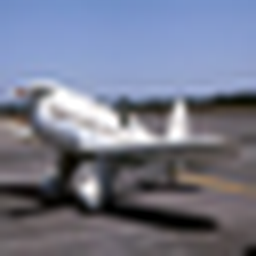

In [32]:
im = Image.fromarray(cifar_dataobj.data[a[-1]]).resize((256,256), Image.ANTIALIAS)
im

In [8]:
import numpy as np
np.unique(cifar_dataobj.targets,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000],
       dtype=int64))

In [24]:
y_train = np.array(cifar_dataobj.targets)
y_train

array([3, 8, 8, ..., 5, 1, 7])

In [275]:
min_size = 0
min_require_size = 10
K = 10
beta=0.01
n_parties=10
N = y_train.shape[0]
net_dataidx_map = {}

In [276]:
while min_size < min_require_size:
    
    idx_batch = [[] for _ in range(n_parties)]
    for k in range(K):
        # select those labels corresponding to the k.
        idx_k = np.where(y_train == k)[0]
        np.random.shuffle(idx_k)
        
        proportions = np.random.dirichlet(np.repeat(beta, n_parties))
        proportions = np.array([p * (len(idx_j) < N / n_parties) for p, idx_j in zip(proportions, idx_batch)])
        proportions = proportions / proportions.sum()
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        idx_batch = [idx_j + idx.tolist() for idx_j, idx in zip(idx_batch, np.split(idx_k, proportions))]
        min_size = min([len(idx_j) for idx_j in idx_batch])

for j in range(n_parties):
    np.random.shuffle(idx_batch[j])
    net_dataidx_map[j] = idx_batch[j]
# net_dataidx_map

In [277]:
def record_net_data_stats(y_train, net_dataidx_map):
    net_cls_counts = {}

    for net_i, dataidx in net_dataidx_map.items():
        unq, unq_cnt = np.unique(y_train[dataidx], return_counts=True)
        tmp = {unq[i]: unq_cnt[i] for i in range(len(unq))}
        net_cls_counts[net_i] = tmp

    data_list=[]
    for net_id, data in net_cls_counts.items():
        n_total=0
        for class_id, n_data in data.items():
            n_total += n_data
        # just data valumes, not related to categories.
        data_list.append(n_total)
    print('mean:', np.mean(data_list))
    print('std:', np.std(data_list))
#     logger.info('Data statistics: %s' % str(net_cls_counts))

    return net_cls_counts

In [278]:
record=record_net_data_stats(y_train,net_dataidx_map)

mean: 1000.0
std: 542.9703490983646


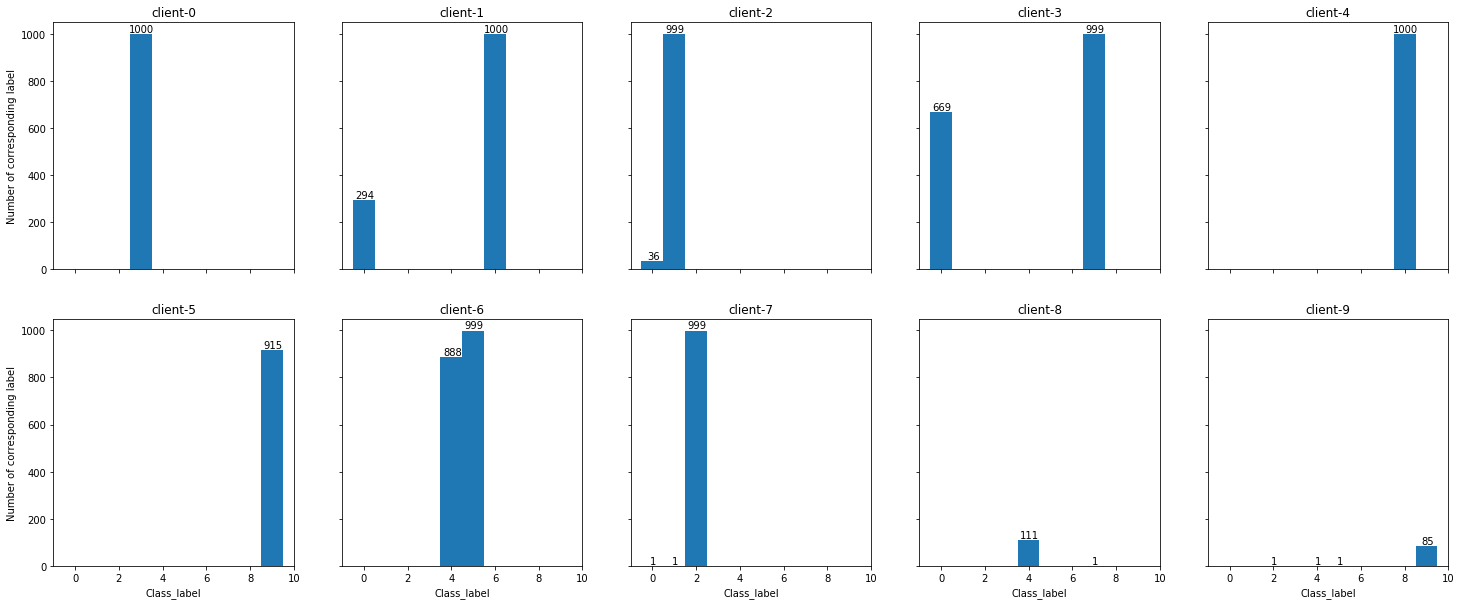

In [279]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 5, sharex='col', sharey='row',figsize=(25,10))
for i in range(n_parties):
    if i==0:
        ax[i//5,i%5].set_ylabel("Number of corresponding label")
    elif i>5:
        ax[i//5,i%5].set_xlabel("Class_label")
    elif i==5:
        ax[i//5,i%5].set_ylabel("Number of corresponding label")
        ax[i//5,i%5].set_xlabel("Class_label")
        
    ax[i//5,i%5].set_xlim(-1,10)
    ax[i//5,i%5].bar(list(record[i].keys()),list(record[i].values()),width = 1)
    ax[i//5,i%5].set_title("client-{0}".format(i))
    for m,n in zip(list(record[i].keys()),list(record[i].values())):
        ax[i//5,i%5].text(m+0.05,n+0.05,'%d' %n, ha='center',va='bottom')

plt.savefig("./beta-{0}-partition.png".format(beta),dpi=300,bbox_inches='tight')
plt.show()

In [199]:
# import collections

# new_record={}
# for i in range(10):
#     for j in range(10):
#         if j not in record[i].keys():
#             record[i][j]=0
#     new_record[i]=collections.OrderedDict(sorted(record[i].items()))
# new_record

# Viaulize

Computing t-SNE embedding


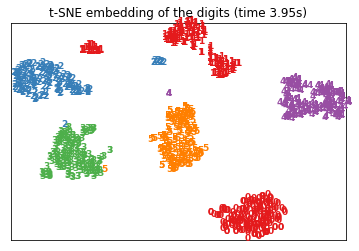

In [41]:
# coding='utf-8'
"""t-SNE对手写数字进行可视化"""
from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.manifold import TSNE


def get_data():
    digits = datasets.load_digits(n_class=6)
    data = digits.data
    label = digits.target
    n_samples, n_features = data.shape
    return data, label, n_samples, n_features


def plot_embedding(data, label, title):
    x_min, x_max = np.min(data, 0), np.max(data, 0)
    data = (data - x_min) / (x_max - x_min)

    fig = plt.figure()
    ax = plt.subplot(111)
    for i in range(data.shape[0]):
        plt.text(data[i, 0], data[i, 1], str(label[i]),
                 color=plt.cm.Set1(label[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([])
    plt.yticks([])
    plt.title(title)
    return fig


def main():
    data, label, n_samples, n_features = get_data()
    print('Computing t-SNE embedding')
    tsne = TSNE(n_components=2, init='pca', random_state=0)
    t0 = time()
    result = tsne.fit_transform(data)
    fig = plot_embedding(result, label,
                         't-SNE embedding of the digits (time %.2fs)'
                         % (time() - t0))
    plt.show(fig)


if __name__ == '__main__':
    main()